In [15]:
import numpy as np
import matplotlib.pyplot as plt
from src.cyc_gbm import CycGBM
from src.cyc_gbm.utils import tune_kappa
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from src.cyc_gbm.distributions import BetaPrimeDistribution

In [17]:
# Simulator
def simulator(z, rng):
    mu  = np.exp(z[0])
    l = np.exp(z[1])
    return rng.wald(mu,l)

# Parameter functions (0:th index in x is constant)
def z_function(x):
    z0 = 0.003*x[:,1]*x[:,2]*x[:,3] + 0.3*np.abs(x[:,4])
    z1 = 1 + 0.3*(x[:,1]>0) + 0.5*x[:,2]*(x[:,5]>0)
    return np.stack([z0,z1])

# Simulate
n = 100000
p = 9
random_seed = 10
rng = np.random.default_rng(seed = random_seed)
X = np.concatenate([np.ones((1,n)),rng.normal(0,1,(p-1,n))]).T
z = z_function(X)
y = simulator(z,rng)

# Set hyperparameters
kappa_max = 100
max_depth = 3
min_samples_leaf = 5
eps = [0.1,0.1]
n_splits = 4
random_state = 5

kappa = tune_kappa(
    X=X,
    y=y,
    kappa_max=kappa_max,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    dist="inv_gauss",
    n_splits=n_splits,
    random_state=random_state,
)

print(kappa)

[34 37]


In [18]:
# Set hyperparameters
BMax = kappa_max
nFolds = n_splits
d = 2
epsilon = eps

dist = BetaPrimeDistribution()
# Loss function
def lossEval(z, y):
    return dist.calculate_loss(z=z, y=y)

# Gradients
def grad0(z, y):
    return dist.calculate_grad(z=z, y=y, j=0)


def grad1(z, y):
    return dist.calculate_grad(z=z, y=y, j=1)

# Gradient list
grads = [grad0, grad1]

kf = KFold(n_splits=nFolds, shuffle=True, random_state=random_state)

# Tree fitting
from sklearn.tree import DecisionTreeRegressor as regressionTree


def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    g = grad(z, y)
    tree.fit(x, -g)
    return tree


# Local tree training function
def trainThisTree(
    z, y, x, grad, max_depth=max_depth, min_samples_leaf=min_samples_leaf
):
    return trainTree(z, y, x, grad, max_depth, min_samples_leaf)


# Evaluation arrays (indexed by fold, boosting step)
lossTrain, lossValid = np.zeros((nFolds, BMax, d)), np.zeros((nFolds, BMax, d))

# Dimension indicator for score adding
e = [np.stack([[0]] * j + [[1]] + [[0]] * (d - j - 1)) for j in range(0, d)]

# Intercept model
xTrain, yTrain = X, y
nTrain = len(yTrain)

toMin = lambda z: lossEval(z, yTrain).sum()
zOpt = minimize(toMin, np.zeros(d))["x"]

# Fit to all folds
for i, idx in enumerate(kf.split(X)):
    # Training and validation data
    idx_train, idx_valid = idx
    xTrain, yTrain = X[idx_train], y[idx_train]
    xValid, yValid = X[idx_valid], y[idx_valid]
    nTrain, nValid = len(yTrain), len(yValid)

    # Initiate score
    zTrain = zOpt.repeat(nTrain).reshape((d, nTrain))
    zValid = zOpt.repeat(nValid).reshape((d, nValid))

    # Initiate loss
    for j in range(0, d):
        lossTrain[i, 0, j] = lossEval(zTrain, yTrain).sum()
        lossValid[i, 0, j] = lossEval(zValid, yValid).sum()

    # Build trees
    for b in range(1, BMax):
        # For all parameter dimensions
        for j in range(0, d):
            # Fit a tree
            tree = trainThisTree(zTrain, yTrain, xTrain, grads[j])

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for k, nodeValue in enumerate(nodeValues):
                # Indices with this node value
                indicesTrain = zTrainPlus == nodeValue
                indicesValid = zValidPlus == nodeValue
                # Optimize step size
                gammaOpt = minimize(
                    lambda gamma: lossEval(
                        zTrain[:, indicesTrain] + e[0] * gamma, yTrain[indicesTrain]
                    ).sum(),
                    jac=lambda gamma: (
                        grad0(
                            zTrain[:, indicesTrain] + e[0] * gamma, yTrain[indicesTrain]
                        )
                    ).sum(),
                    x0=nodeValue,
                )["x"][0]
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j] * zTrainPlus
            zValid[j] += epsilon[j] * zValidPlus

            # Update loss
            lossTrain[i, b, j] = lossEval(zTrain, yTrain).sum()
            lossValid[i, b, j] = lossEval(zValid, yValid).sum()

        # Check breaking criteria
        if (
            lossValid[i, b, 0] > lossValid[i, b - 1, 1]
            and lossValid[i, b, 1] > lossValid[i, b, 0]
        ):
            lossTrain[i, b + 1 :, :] = lossTrain[i, b, -1]
            lossValid[i, b + 1 :, :] = lossValid[i, b, -1]
            break

# Sum the losses
lossTrainTot = lossTrain.sum(axis=0)[:, -1]
lossValidTot = lossValid.sum(axis=0)[:, -1]

# Calculate loss improvements
lossValidPerUpdate = lossValid.sum(axis=0)
lossImprovement = np.zeros((BMax, d))
lossImprovement[1:, 0] = lossValidPerUpdate[1:, 0] - lossValidPerUpdate[:-1, 1]
lossImprovement[1:, 1] = lossValidPerUpdate[1:, 1] - lossValidPerUpdate[1:, 0]

# Pick optimal number of boosters
BOpts = np.argmax(lossImprovement[1:] > 0, axis=0)
BOpt = int(max(BOpts))
[print(f"BOpt {j}: {int(BOpts[j])}") for j in range(0, d)]

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(16, 16 / 1.61))

# Show validation losses
axs[0].plot(lossTrainTot[: BOpt + 2] / np.abs(lossTrainTot[0]), label="Training")
axs[0].plot(lossValidTot[: BOpt + 2] / np.abs(lossValidTot[0]), label="Validation")
axs[0].legend()
axs[0].set_title("Total loss")
axs[0].set_xlim([0, BOpt + 1])

# Show loss improvements
colors = ["tab:green", "tab:red"]
for j in range(0, d):
    axs[1].plot(
        np.arange(1, BOpt + 3),
        lossImprovement[1 : BOpt + 3, j],
        label=param_names[j],
        color=colors[j],
    )
    axs[1].axvline(BOpts[j], linestyle="--", color=colors[j])

axs[1].legend()
axs[1].set_title("Loss improvement")
axs[1].set_xlim([1, BOpt + 1]);

NameError: name 'param_names' is not defined

In [ ]:
plt.plot(lossValidTot[:20] / lossValidTot[0])

BOpt 0: 38
BOpt 1: 31


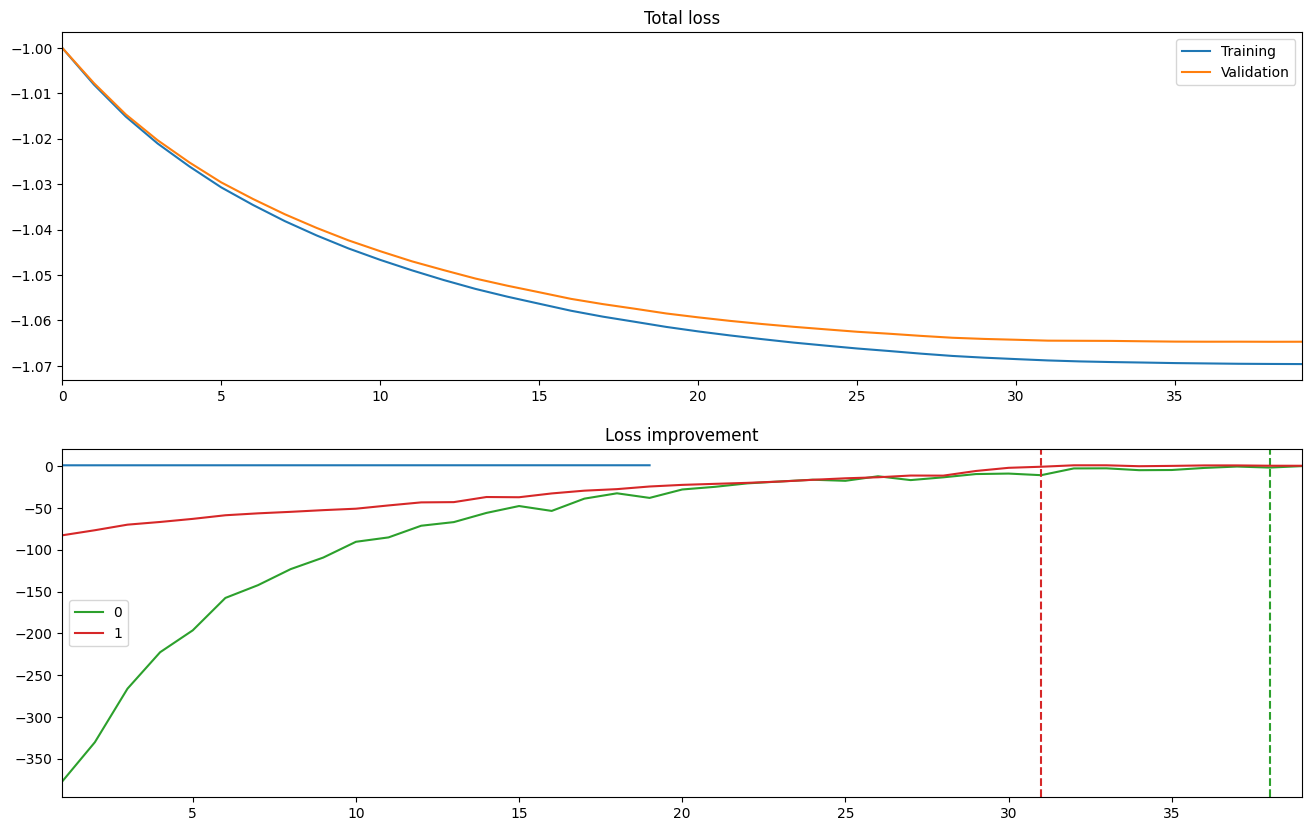

In [20]:
[print(f"BOpt {j}: {int(BOpts[j])}") for j in range(0, d)]

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(16, 16 / 1.61))

# Show validation losses
axs[0].plot(lossTrainTot[: BOpt + 2] / np.abs(lossTrainTot[0]), label="Training")
axs[0].plot(lossValidTot[: BOpt + 2] / np.abs(lossValidTot[0]), label="Validation")
axs[0].legend()
axs[0].set_title("Total loss")
axs[0].set_xlim([0, BOpt + 1])

# Show loss improvements
colors = ["tab:green", "tab:red"]
for j in range(0, d):
    axs[1].plot(
        np.arange(1, BOpt + 3),
        lossImprovement[1: BOpt + 3, j],
        label=j,
        color=colors[j],
    )
    axs[1].axvline(BOpts[j], linestyle="--", color=colors[j])

axs[1].legend()
axs[1].set_title("Loss improvement")
axs[1].set_xlim([1, BOpt + 1]);
plt.plot(lossValidTot[:20] / lossValidTot[0])

In [ ]:
loss_total = loss.sum(axis=0)[:, -1]
plt.plot(loss_total[:20] / loss_total[0])
